## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import itertools as it

***Переведем столбец datetime в тип дата и назначим его индексом.***

In [319]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [320]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [321]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


***Отсортировали данные в хронологическом порядке и провели ресемплирование по часу***

In [322]:
data.sort_index(inplace=True)

In [323]:
data = data.resample('1H').sum()

# 2. Анализ

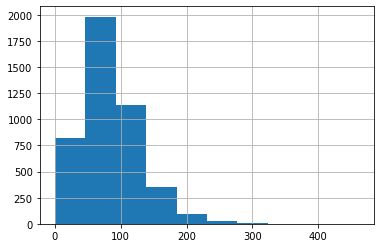

In [324]:
data['num_orders'].hist();

In [325]:
data['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

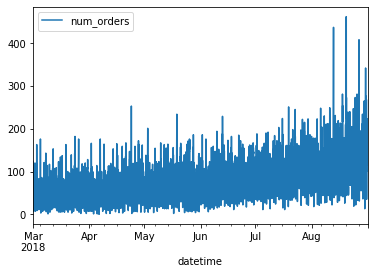

In [326]:
data.plot(ax = plt.gca());

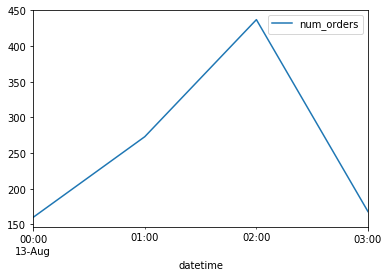

In [327]:
data['2018-08-13 00:00:00':'2018-08-13 03:00:00'].plot(ax = plt.gca());

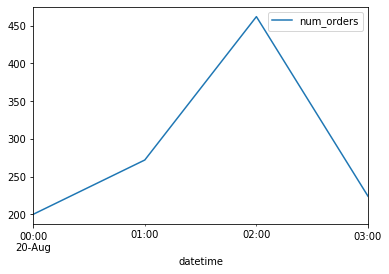

In [328]:
data['2018-08-20 00:00:00':'2018-08-20 03:00:00'].plot(ax = plt.gca());

***Два пика 13 августа и 20-го в районе 2-ух часов ночи. Отправление и прибытие отдыхающих;)***

***Скользящее среднее***

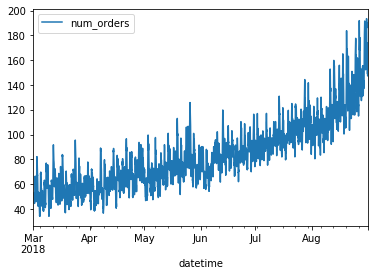

In [329]:
data.rolling(15).mean().plot(ax = plt.gca());

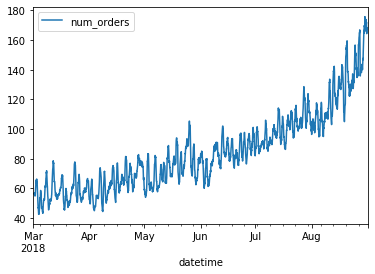

In [330]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot();

***Чем становится теплее, больше путешественников и отдыхающих, а конце августа кто не успел, пытаются наверсать упущенное. Есть тренд к постоянному увеличению заказов с марта по август.Стационарности нет, так как среднее разное***

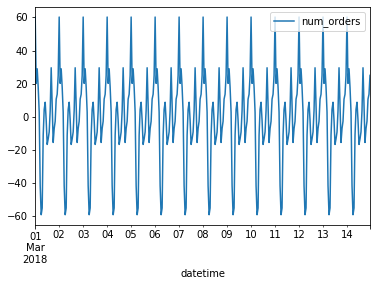

In [331]:
decomposed = seasonal_decompose(data)

decomposed.seasonal['2018-03-01':'2018-03-14'].plot(ax=plt.gca());

***Сезонность наблюдается в разрезе дня***

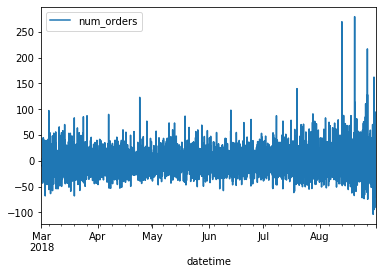

In [332]:
decomposed = seasonal_decompose(data)
decomposed.resid.plot();

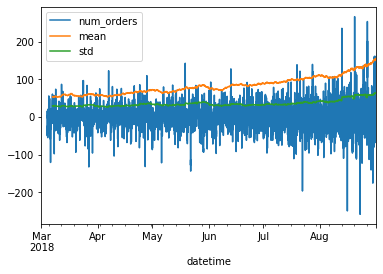

In [333]:
data_shift = data - data.shift(72)
data_shift['mean'] = data['num_orders'].rolling(148).mean()
data_shift['std'] = data['num_orders'].rolling(148).std()
data_shift.plot();

***Очень много шума в данных. Необходимо выбрать нужное значение скользящего среднего и отстающих знаечний, чтобы минимизировать влияние шума***

# 3. Обучение

In [334]:
data['year'] = data.index.year    
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

***Пока не совладал с собственным поиском по сетке:(
не хочет обрабатывать больше трех комбинаций параметров rolling и lag, видимо неправильно делятся данные на train и valid. Или все дело в том, что я пытаюсь это реализовать через функцию, а нужно через класс/метод...Посмотри, пожалуйста, что не так!***

***Поиск реализовал перебором комбинаций всех сочетаний rolling и lag (освоил итератор). Когда нужная комбинация найдена, функция возвращает преобразованный датасет.***

In [336]:
def rolling_search(df,rolling_params):
    
    roll_combinations = list(it.product(*(rolling_params[Name] for Name in rolling_params)))
    
    roll_keys = list(rolling_params.keys())
    
    r = pd.DataFrame(data = roll_combinations, columns = roll_keys)
        
    final_score = []
    
    scores = []
    
    df.reset_index(inplace = True)
    
    df.loc[:,'datetime'] = df.loc[:,'datetime'].astype(np.int64)
    
#--------------------------------------------------------    
    
    for roll_comb in roll_combinations:
                             
        for lag in range(1, roll_comb[0]):
                               
            df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

        df['rolling_mean'] = df['num_orders'].shift().rolling(roll_comb[1]).mean()
        
#---------------------------------------------------------       

        df.dropna(inplace = True)
                
        features = df.drop('num_orders', axis = 1)
                
        target = df['num_orders']
        
        features_train, features_test, target_train, target_test =\
        train_test_split(features,target, shuffle = False, test_size = 0.1)
         
        mean_score = []
            
        model = LinearRegression()
        
        model.fit(features_train, target_train)
            
        pred = model.predict(features_train)
        
        scores.append(np.sqrt(abs(mean_squared_error(target_train, pred))))
                
    r['scores'] = scores         
    
    if len(roll_combinations) == 1:
        return data
    else:
        print('Best params:\n',r.sort_values('scores').iloc[0])

In [338]:
def make_features(df, max_lag, rolling_mean_size):
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    df.dropna(inplace = True)
    
    return df

In [339]:
scoring = []

<h3>LinearRegression</h3>

***max_lag = 24,72 rolling_mean_size = 72,48***

In [340]:
rolling_param = {'max_lag' : [24,72], 'rolling_mean_size' : [48,72]}

In [341]:
lag_roll = list(it.product(*(rolling_param[Name] for Name in rolling_param)))

In [342]:
for lr in lag_roll:
    new_data = make_features(data,lr[0],lr[1]).copy()
    features = new_data.drop('num_orders', axis = 1)
    target = new_data['num_orders']
    param_grid = {'normalize' : [False,True]}
    model = LinearRegression()
    l_grid = GridSearchCV(model, param_grid, cv = TimeSeriesSplit(n_splits = 5), 
                          scoring = 'neg_mean_squared_error', verbose = 0)
    l_grid.fit(features, target)
    print(lr,np.sqrt(abs(l_grid.best_score_)))

(24, 48) 30.66124340927372
(24, 72) 30.46354283473095
(72, 48) 27.567205462171003
(72, 72) 27.685637458468044


***Выберем (max_lag = 72, rolling_mean_size = 48)***

In [343]:
new_data = make_features(data,72,48).copy()

train, test = train_test_split(data_1, shuffle = False, test_size = 0.1)
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

param_grid = {'normalize' : [False,True]}
model = LinearRegression()
l_grid = GridSearchCV(model, param_grid, cv = TimeSeriesSplit(n_splits = 5), 
                          scoring = 'neg_mean_squared_error', verbose = 0)

In [344]:
l_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None, param_grid={'normalize': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [345]:
scoring.append(np.sqrt(abs(l_grid.best_score_)))
print("Лучшая модель:\n{} : {}".format(l_grid.best_params_, 
                                       np.sqrt(abs(l_grid.best_score_))))

Лучшая модель:
{'normalize': False} : 27.326500035443527


---
<h3>LightGBM</h3>

In [346]:
gbm_model = LGBMRegressor()
param_grid = {
    'n_estimators': [400, 600, 800],
    'max_depth': [8]
}   
gbm_grid = GridSearchCV(gbm_model, param_grid, cv = TimeSeriesSplit(), scoring = 'neg_mean_squared_error') 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


In [347]:
%%time

gbm_grid.fit(X_train, y_train)

CPU times: user 1min 25s, sys: 531 ms, total: 1min 26s
Wall time: 1min 27s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [8], 'n_estimators': [400, 600, 800]},
             pre_dispatch='2*n_jo

In [348]:
scoring.append(np.sqrt(abs(gbm_grid.best_score_)))
print("Лучшая модель:\n{} : {}".format(gbm_grid.best_params_, 
                                       np.sqrt(abs(gbm_grid.best_score_))))

Лучшая модель:
{'max_depth': 8, 'n_estimators': 400} : 27.766182754509302


---
<h3>CatBoost</h3>

In [349]:
cat_model = CatBoostRegressor(loss_function = 'RMSE', verbose = False)

param_grid = {    'iterations': [300, 500, 800], 
                  'depth' : [4,6,8],          
                 }
cat_grid = GridSearchCV(cat_model, param_grid, cv = TimeSeriesSplit(), scoring = 'neg_mean_squared_error') 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


In [350]:
%%time

cat_grid.fit(X_train, y_train)

CPU times: user 6min 45s, sys: 50 s, total: 7min 35s
Wall time: 8min 18s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f5e70174190>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [4, 6, 8], 'iterations': [300, 500, 800]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [351]:
scoring.append(np.sqrt(abs(cat_grid.best_score_)))
print("Лучшая модель:\n{} : {}".format(cat_grid.best_params_, 
                                       np.sqrt(abs(cat_grid.best_score_))))

Лучшая модель:
{'depth': 6, 'iterations': 800} : 26.779999860224954


In [353]:
pd.DataFrame({'model': ['LinearRegression', 'LightGBM', 'CatBoost'], 
              'train_score': scoring})

,model,train_score
0,LinearRegression,27.326500
1,LightGBM,27.766183
2,CatBoost,26.780000


***Наилучшие показатели у модели, обученной CatBoost, возьмем ее для тестирования***

# 4. Тестирование

In [354]:
print("Правильность на тесте: {:.2f}". \
      format(np.sqrt(abs(cat_grid.score(X_test, y_test)))))

Правильность на тесте: 41.59


***Очень большой "вклад" в данные вносят шумы. Используя отстающее значение, равным 72 и Скользящее среднее 48, при прогнозе количества заказов такси на следующий час мы в среднем ошибаемся на 41 машину.***

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48